# Bước 5: So sánh Apriori vs FP-Growth

Mục tiêu:

- Chạy Apriori và FP-Growth trên cùng một `basket_bool`
- So sánh:
  - Thời gian chạy
  - Số lượng tập mục phổ biến (frequent itemsets)
  - Số lượng luật kết hợp sinh ra
  - Độ dài trung bình của itemset
- Minh hoạ bằng biểu đồ để sinh viên thấy rõ trade-off giữa:
  - Độ đầy đủ của luật
  - Thời gian tính toán
  - Tính phù hợp với dữ liệu lớn


In [1]:
# PARAMETERS (for papermill)

BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"

# Dùng chung tham số với hai thuật toán
MIN_SUPPORT = 0.01
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0


In [2]:
# Parameters
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"
MIN_SUPPORT = 0.1
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0


## Set up

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import (
    benchmark_apriori_vs_fpgrowth,
    AssociationRulesMiner,
    FPGrowthMiner,
    DataVisualizer,
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


## Tải basket_bool

In [4]:
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")


=== Thông tin basket_bool ===
- Số hoá đơn (rows): 18,021
- Số sản phẩm (columns): 4,007
- Tỷ lệ ô = 1 (có mua): 0.0066


## Chạy benchmark

In [5]:
result = benchmark_apriori_vs_fpgrowth(
    basket_bool=basket_bool,
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

summary = result["summary"]
summary


,algorithm,runtime_sec,n_itemsets,n_rules,avg_itemset_length
0,apriori,0.066231,2,0,1.0
1,fpgrowth,2.283537,2,0,1.0


## Biểu đồ so sánh thời gian

D:\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
D:\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
D:\anaconda3\envs\shopping_env\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


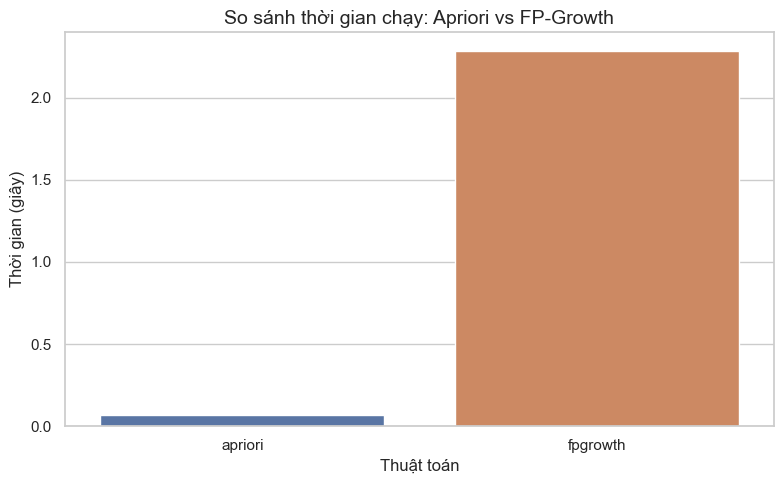

In [6]:
plt.figure()
sns.barplot(data=summary, x="algorithm", y="runtime_sec")
plt.title("So sánh thời gian chạy: Apriori vs FP-Growth")
plt.ylabel("Thời gian (giây)")
plt.xlabel("Thuật toán")
plt.tight_layout()
plt.show()


## Biểu đồ số lượng itemsets & rules

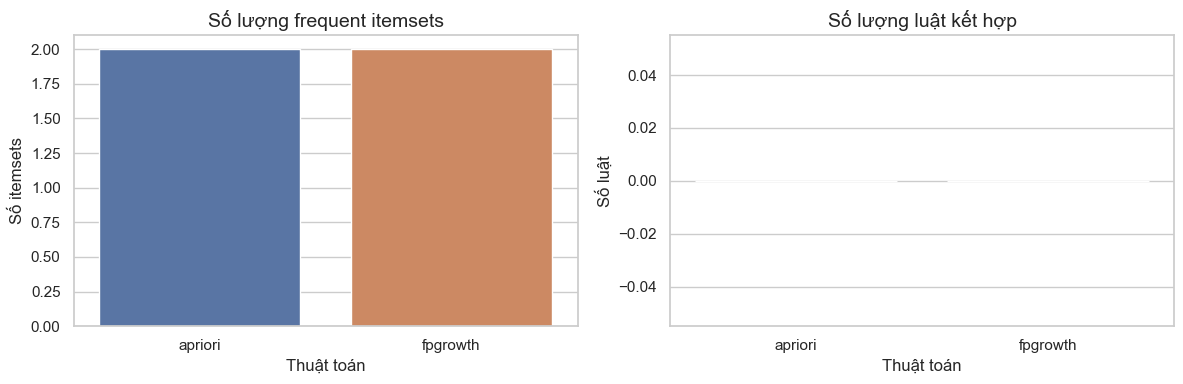

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=summary, x="algorithm", y="n_itemsets", ax=axes[0])
axes[0].set_title("Số lượng frequent itemsets")
axes[0].set_xlabel("Thuật toán")
axes[0].set_ylabel("Số itemsets")

sns.barplot(data=summary, x="algorithm", y="n_rules", ax=axes[1])
axes[1].set_title("Số lượng luật kết hợp")
axes[1].set_xlabel("Thuật toán")
axes[1].set_ylabel("Số luật")

plt.tight_layout()
plt.show()


## Độ dài trung bình iemset

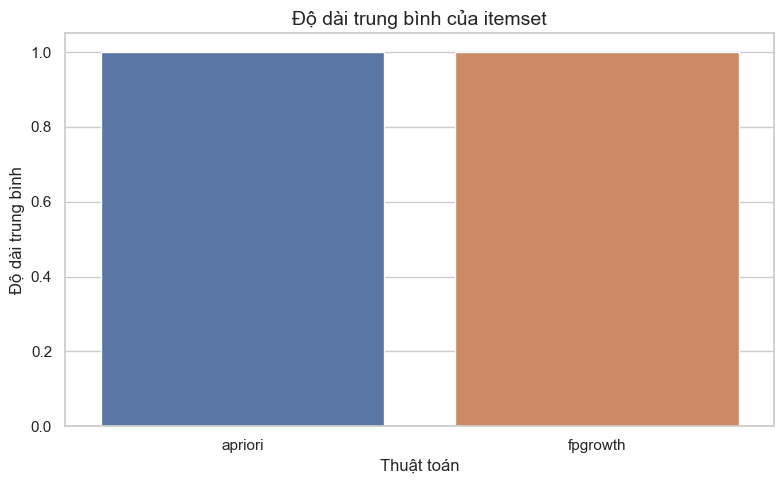

In [8]:
plt.figure()
sns.barplot(data=summary, x="algorithm", y="avg_itemset_length")
plt.title("Độ dài trung bình của itemset")
plt.xlabel("Thuật toán")
plt.ylabel("Độ dài trung bình")
plt.tight_layout()
plt.show()


## Một vài luật tiêu biểu từ mỗi thuật toán

In [9]:
cols_preview = [
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift",
]

ap_rules = result["apriori_rules"].copy()
fp_rules = result["fpgrowth_rules"].copy()

# Thêm dạng chuỗi dễ đọc nếu chưa có (tuỳ trường hợp gọi)
if "antecedents_str" not in ap_rules.columns:
    miner_ap_tmp = AssociationRulesMiner(basket_bool=basket_bool)
    miner_ap_tmp.frequent_itemsets = result["apriori_itemsets"]
    miner_ap_tmp.rules = ap_rules
    ap_rules = miner_ap_tmp.add_readable_rule_str()

if "antecedents_str" not in fp_rules.columns:
    miner_fp_tmp = FPGrowthMiner(basket_bool=basket_bool)
    miner_fp_tmp.frequent_itemsets = result["fpgrowth_itemsets"]
    miner_fp_tmp.rules = fp_rules
    fp_rules = miner_fp_tmp.add_readable_rule_str()

print("=== Top 10 luật Apriori (theo lift) ===")
display(
    ap_rules.sort_values("lift", ascending=False)[cols_preview].head(10)
)

print("=== Top 10 luật FP-Growth (theo lift) ===")
display(
    fp_rules.sort_values("lift", ascending=False)[cols_preview].head(10)
)


=== Top 10 luật Apriori (theo lift) ===


,antecedents_str,consequents_str,support,confidence,lift


=== Top 10 luật FP-Growth (theo lift) ===


,antecedents_str,consequents_str,support,confidence,lift
